In [7]:
%matplotlib inline
import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

In [57]:
# Step 1: Download the data.
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [58]:
# Read the data into a list of strings.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_data(filename)
print('Data size', len(vocabulary))


Data size 17005207


In [60]:
vocabulary[:500]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes',
 'of',
 'the',
 'french',
 'revolution',
 'whilst',
 'the',
 'term',
 'is',
 'still',
 'used',
 'in',
 'a',
 'pejorative',
 'way',
 'to',
 'describe',
 'any',
 'act',
 'that',
 'used',
 'violent',
 'means',
 'to',
 'destroy',
 'the',
 'organization',
 'of',
 'society',
 'it',
 'has',
 'also',
 'been',
 'taken',
 'up',
 'as',
 'a',
 'positive',
 'label',
 'by',
 'self',
 'defined',
 'anarchists',
 'the',
 'word',
 'anarchism',
 'is',
 'derived',
 'from',
 'the',
 'greek',
 'without',
 'archons',
 'ruler',
 'chief',
 'king',
 'anarchism',
 'as',
 'a',
 'political',
 'philosophy',
 'is',
 'the',
 'belief',
 'that',
 'rulers',
 'are',
 'unnecessary',
 'and',
 'should',
 'be',
 'abolished',
 'although',
 'there',
 'are',
 'differing',
 '

In [23]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 50000

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5236, 3084, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [25]:
data[:5]

[5236, 3084, 12, 6, 195]

In [13]:
data_index = 0
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        if data_index == len(data):
            buffer[:] = data[:span]
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3081 originated -> 12 as
3081 originated -> 5241 anarchism
12 as -> 6 a
12 as -> 3081 originated
6 a -> 12 as
6 a -> 195 term
195 term -> 2 of
195 term -> 6 a


In [16]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

In [6]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()


NameError: name 'batch_size' is not defined

In [18]:
# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
            for k in xrange(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log_str = '%s %s,' % (log_str, close_word)
            print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  284.43145752
Nearest to seven: patria, malinche, shrews, germination, gypsum, spying, dominant, participating,
Average loss at step  2000 :  113.781119667
Average loss at step  4000 :  53.0693176386
Average loss at step  6000 :  33.3692354639
Average loss at step  8000 :  23.1171767082
Average loss at step  10000 :  17.9742590259
Nearest to seven: zero, nine, tourism, eight, one, leakey, cl, four,
Average loss at step  12000 :  13.7398667729
Average loss at step  14000 :  11.7117530541
Average loss at step  16000 :  9.93120708275
Average loss at step  18000 :  8.43264756447
Average loss at step  20000 :  8.05497237885
Nearest to seven: eight, nine, zero, four, three, six, two, five,
Average loss at step  22000 :  6.98378829074
Average loss at step  24000 :  6.9110080297
Average loss at step  26000 :  6.77577403152
Average loss at step  28000 :  6.37777883065
Average loss at step  30000 :  5.93498344767
Nearest to seven: eight, nine, four, five, si

In [19]:
final_embeddings

array([[ 0.03000719, -0.06669949, -0.1196632 , ..., -0.02753697,
         0.07600632, -0.15803853],
       [ 0.01229322, -0.0614956 , -0.08662079, ...,  0.07621253,
         0.09354065, -0.09217851],
       [-0.00559081, -0.00787216, -0.17968884, ..., -0.05377081,
        -0.16877705, -0.12086439],
       ..., 
       [ 0.03803191,  0.09338591,  0.01845264, ..., -0.13851362,
         0.03815269,  0.09688416],
       [-0.13413863,  0.0052078 ,  0.05749273, ..., -0.0797421 ,
         0.11530533,  0.0597991 ],
       [ 0.06996341,  0.06207399,  0.03707814, ..., -0.13247934,
         0.0396421 ,  0.0125712 ]], dtype=float32)

In [79]:
#np.save('final_embeddings', final_embeddings)

In [22]:
# final_embeddings = np.load('./final_embeddings.npy')


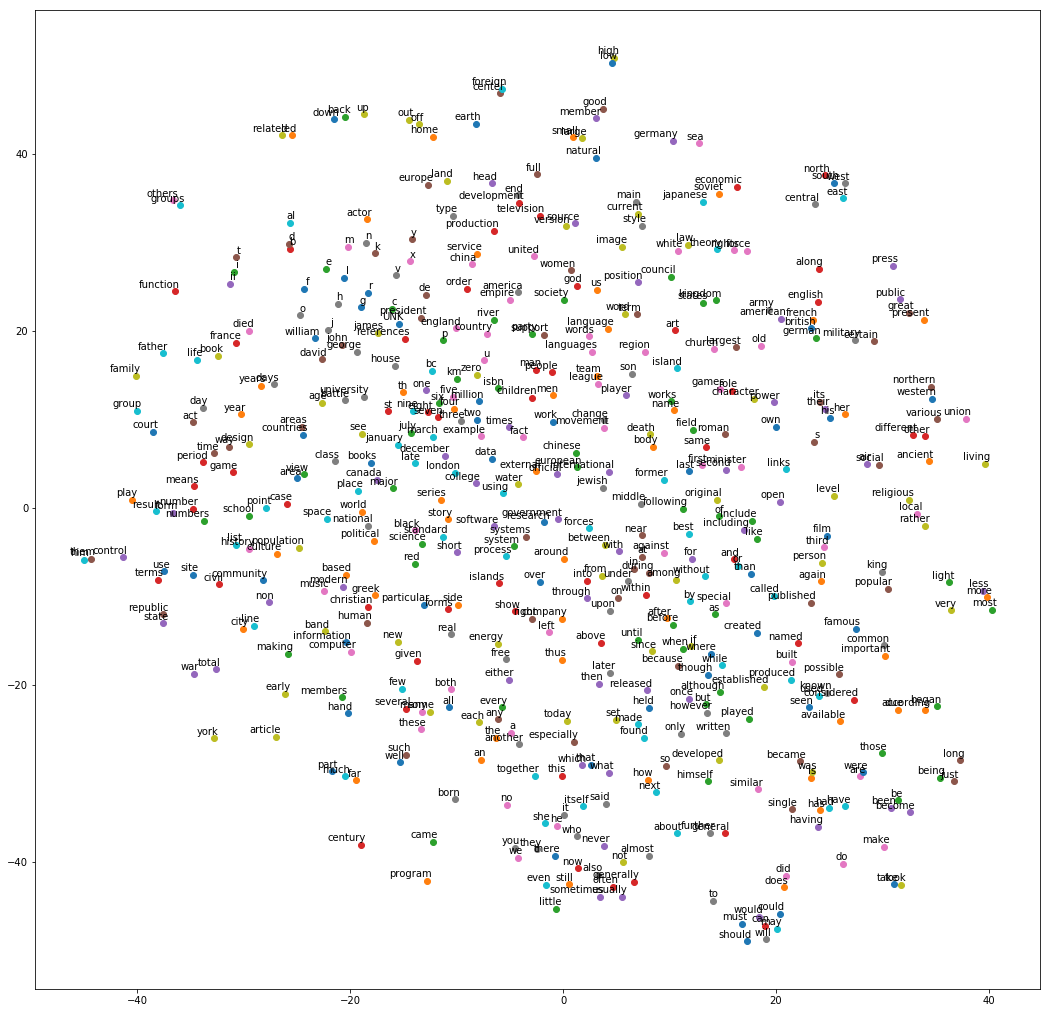

In [23]:
# Step 6: Visualize the embeddings.


def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

    plt.savefig(filename)

try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError as e:
    print(e)
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')

# Word2Vec for Chinese FB fan page data

In [39]:
from datetime import datetime
from elasticsearch import Elasticsearch
import re
import jieba

In [14]:
es = Elasticsearch([{'host': '192.168.2.13', 'port': 9200}])
es_index = 'facebook'
es_post_doc_type = 'post'
es_comment_and_reaction_doc_type = 'action'

In [40]:
def remove_url_and_punctuation(sentence):
    # remove url
    if 'http' in sentence:
        sentence = re.sub(r'[a-zA-Z0-9_/:.]', '', sentence, flags=re.MULTILINE)

    # remove punctuation
    text_list = re.split('\W+', sentence)
    return list(filter(None, text_list))

# Todo use mutual information
def chinese_segmentation(text_list):
    return_list = []
    for sentence in text_list:
        return_list.extend(list(jieba.cut(sentence, cut_all=False)))
    return return_list

In [48]:
# query all comment
page = es.search(
    index=es_index,
    doc_type=es_comment_and_reaction_doc_type,
    scroll = '2m',
    size = 1000,
    body={"query": {"match_all": {}}})
print("Got %d Hits:" % page['hits']['total'])
sid = page['_scroll_id']
scroll_size = page['hits']['total']
data = []
# Start scrolling
print("Scrolling...")
while (scroll_size > 0):
    page = es.scroll(scroll_id = sid, scroll = '2m')
    # Update the scroll ID
    sid = page['_scroll_id']
    # Get the number of results that we returned in the last scroll
    scroll_size = len(page['hits']['hits'])
#     print("scroll size: " + str(scroll_size))
    # Do something with the obtained page
    for hit in page['hits']['hits']:
        comment = chinese_segmentation(remove_url_and_punctuation(hit['_source']['message']))
        data.extend(comment)

Got 946635 Hits:
Scrolling...


In [50]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 50000

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(data,
                                                            vocabulary_size)
# del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 179701], ('的', 221899), ('是', 123864), ('我', 122357), ('了', 106703)]
Sample data [115, 45, 68, 4368, 4, 36, 3, 53, 57, 18902] ['幹', '這個', '太', '邪惡', '了', '啦', '我', '覺得', '她', '口齒']


In [112]:
reverse_dictionary[115]

'幹'

In [62]:
data_index = 0
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        if data_index == len(data):
            for word in data[:span]:
                buffer.append(word)
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

45 這個 -> 68 太
45 這個 -> 115 幹
68 太 -> 4368 邪惡
68 太 -> 45 這個
4368 邪惡 -> 68 太
4368 邪惡 -> 4 了
4 了 -> 4368 邪惡
4 了 -> 36 啦


In [54]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

In [55]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()


In [63]:
# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
            for k in xrange(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log_str = '%s %s,' % (log_str, close_word)
            print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  262.435272217
Nearest to 這樣: 水有, 乃至, 沒設, 決, 2cm, 這位, G8, 重辦,
Average loss at step  2000 :  114.984913352
Average loss at step  4000 :  53.6691597898
Average loss at step  6000 :  34.8411876423
Average loss at step  8000 :  23.9282570438
Average loss at step  10000 :  18.3557758689
Nearest to 這樣: 導致, 回答, 重辦, 這位, UNK, 無薪假, 字眼, 危機,
Average loss at step  12000 :  14.1551986966
Average loss at step  14000 :  11.8774341565
Average loss at step  16000 :  10.5706370001
Average loss at step  18000 :  9.40559068799
Average loss at step  20000 :  8.52837346554
Nearest to 這樣: 俊榮, 回答, UNK, 導致, 秘境, 字眼, 重辦, 這位,
Average loss at step  22000 :  7.69637729716
Average loss at step  24000 :  7.09905015481
Average loss at step  26000 :  6.97097671437
Average loss at step  28000 :  6.59481120813
Average loss at step  30000 :  9.58045078682
Nearest to 這樣: 俊榮, 想, main, 燚, 重辦, 導致, 圞, 性教育,
Average loss at step  32000 :  7.41015126014
Average loss at step  34000 :  20.918590

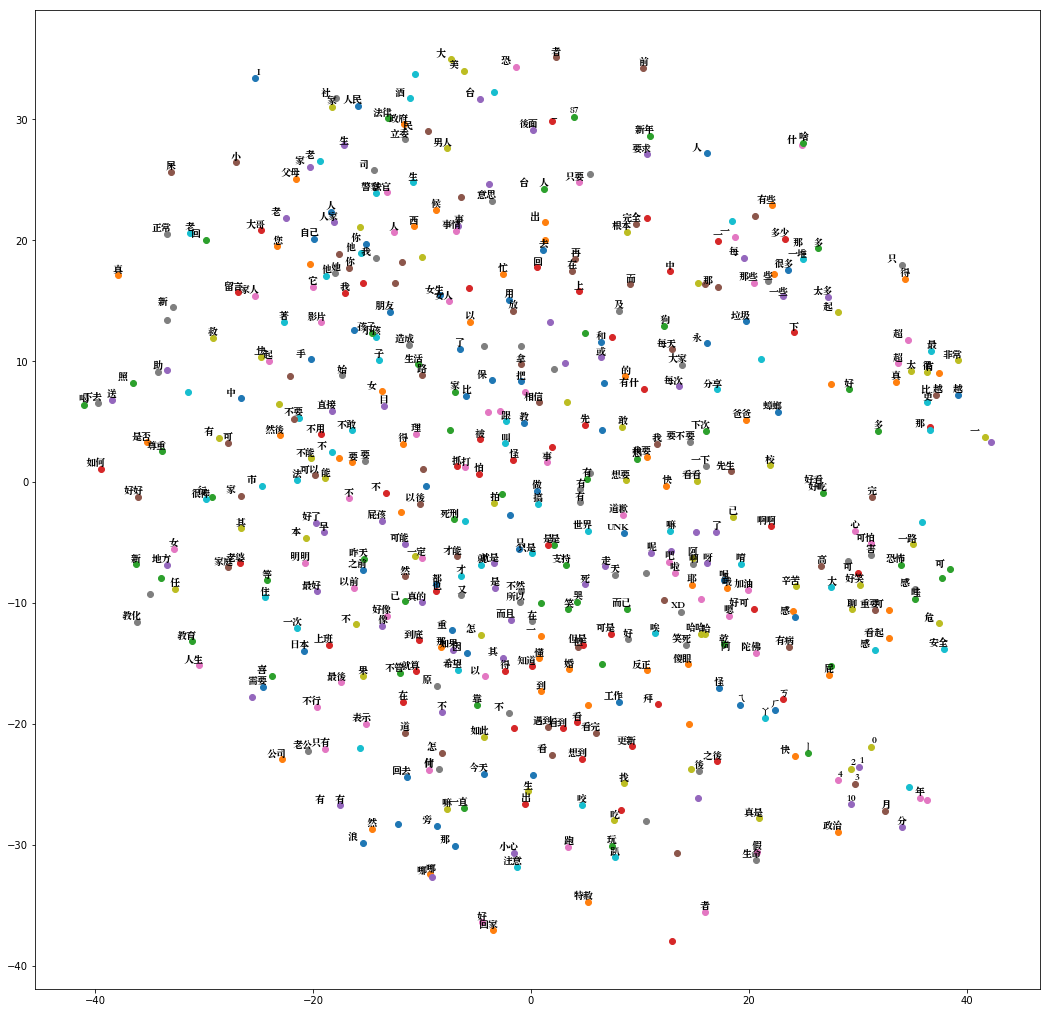

In [66]:
# Step 6: Visualize the embeddings.
from matplotlib.font_manager import FontProperties
ChineseFont = FontProperties(fname ='/home/phejimlin/Public/Songti.ttc')


def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 fontproperties=ChineseFont)

    plt.savefig(filename)

try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError as e:
    print(e)
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')

In [124]:
final_embeddings

array([[ 0.01144462,  0.03345611, -0.06373142, ..., -0.03065585,
        -0.23933262, -0.02530745],
       [ 0.0596878 ,  0.05936367, -0.03441215, ...,  0.01869999,
        -0.13061382, -0.028325  ],
       [ 0.02640911, -0.0605689 , -0.08202004, ...,  0.09070581,
        -0.0395996 , -0.12669486],
       ..., 
       [-0.03946031,  0.07701548, -0.08146602, ..., -0.14375867,
        -0.05284719,  0.07551057],
       [ 0.09043797, -0.09853463, -0.09324155, ..., -0.02107598,
        -0.01174821,  0.023464  ],
       [-0.14535736,  0.08096028,  0.12690142, ..., -0.16387327,
        -0.00685876,  0.00190714]], dtype=float32)

In [145]:
word_index = [dictionary["幹"]]

In [146]:
vocabulary_size = 50000
embedding_size = 128  # Dimension of the embedding vector.
graph = tf.Graph()

with graph.as_default():
    embeddings = tf.Variable(tf.constant(0.0, shape=[vocabulary_size, embedding_size]),
                    trainable=False, name="W")

    embedding_placeholder = tf.placeholder(tf.float32, [vocabulary_size, embedding_size])
    embedding_init = embeddings.assign(embedding_placeholder)  # assign exist word embeddings

    valid_dataset = tf.constant(word_index, dtype=tf.int32)
    valid_embeddings = tf.nn.embedding_lookup(embeddings, valid_dataset)

    # calculate cosine similarity
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    similarity = tf.matmul(
          valid_embeddings, normalized_embeddings, transpose_b=True)
    
    # calculate cosine similarity
#     normed_embedding = tf.nn.l2_normalize(embeddings, dim=1)
#     normed_array = tf.nn.l2_normalize(valid_embeddings, dim=1)
#     similarity = tf.matmul(normed_array, tf.transpose(normed_embedding, [1, 0]))

    
     # Add variable initializer.
    init = tf.global_variables_initializer()

In [147]:
with tf.Session(graph=graph) as session:
    init.run()    
    session.run(embedding_init, feed_dict={embedding_placeholder: final_embeddings})
    
    sim = similarity.eval()
    
    valid_word = reverse_dictionary[word_index[0]]
    top_k = 10  # number of nearest neighbors
    nearest = (-sim[0]).argsort()[1:top_k + 1]
    log_str = 'Nearest to %s:' % valid_word
    for k in xrange(top_k):
        close_word = reverse_dictionary[nearest[k]]
        log_str = '%s %s,' % (log_str, close_word)
    print(log_str)

Nearest to 幹: 啦, XD, 支持, 哈哈, UNK, 報幾, 白癡, 阿, 圞, 喔,


# CNN 

In [151]:
class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(
      self, sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(
                tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                filter_shape = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    filter_shape,
                    strides=[1, 1, 1, 1],  # strides size change will cause cnn result different
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],  
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])  # flatten pooling layers

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable(
                "W",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [152]:
from collections import Counter


def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


def load_data_and_labels(positive_data_file, negative_data_file):
    """
    Loads MR polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load data from files
    positive_examples = list(open(positive_data_file, "r").readlines())
    positive_examples = [s.strip() for s in positive_examples]
    negative_examples = list(open(negative_data_file, "r").readlines())
    negative_examples = [s.strip() for s in negative_examples]
    # Split by words
    x_text = positive_examples + negative_examples
    x_text = [clean_str(sent) for sent in x_text]
    # Generate labels
    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    return [x_text, y]


def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [ ]:
import os
import time
import datetime
from tensorflow.contrib import learn

# Parameters
# ==================================================

# Data loading params
tf.flags.DEFINE_float("dev_sample_percentage", .1, "Percentage of the training data to use for validation")
tf.flags.DEFINE_string("positive_data_file", "./data/rt-polarity.pos", "Data source for the positive data.")
tf.flags.DEFINE_string("negative_data_file", "./data/rt-polarity.neg", "Data source for the negative data.")

# Model Hyperparameters
tf.flags.DEFINE_integer("embedding_dim", 128, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_string("filter_sizes", "3,4,5", "Comma-separated filter sizes (default: '3,4,5')")
tf.flags.DEFINE_integer("num_filters", 128, "Number of filters per filter size (default: 128)")
tf.flags.DEFINE_float("dropout_keep_prob", 0.5, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("l2_reg_lambda", 0.0, "L2 regularization lambda (default: 0.0)")

# Training parameters
tf.flags.DEFINE_integer("batch_size", 64, "Batch Size (default: 64)")
tf.flags.DEFINE_integer("num_epochs", 200, "Number of training epochs (default: 200)")
tf.flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)")
tf.flags.DEFINE_integer("num_checkpoints", 5, "Number of checkpoints to store (default: 5)")
# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")

FLAGS = tf.flags.FLAGS
FLAGS._parse_flags()
print("\nParameters:")
for attr, value in sorted(FLAGS.__flags.items()):
    print("{}={}".format(attr.upper(), value))
print("")

In [ ]:
# Data Preparation
# ==================================================

# Load data
print("Loading data...")
x_text, y = load_data_and_labels(FLAGS.positive_data_file, FLAGS.negative_data_file)

# Build vocabulary
max_document_length = max([len(x.split(" ")) for x in x_text])
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
x = np.array(list(vocab_processor.fit_transform(x_text)))

# Randomly shuffle data
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

# Split train/test set
# TODO: This is very crude, should use cross-validation
dev_sample_index = -1 * int(FLAGS.dev_sample_percentage * float(len(y)))
x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]
print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))


# Training
# ==================================================

with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=FLAGS.allow_soft_placement,
      log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        cnn = TextCNN(
            sequence_length=x_train.shape[1],
            num_classes=y_train.shape[1],
            vocab_size=len(vocab_processor.vocabulary_),
            embedding_size=FLAGS.embedding_dim,
            filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
            num_filters=FLAGS.num_filters,
            l2_reg_lambda=FLAGS.l2_reg_lambda)

        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        # Train Summaries
        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints)

        # Write vocabulary
        vocab_processor.save(os.path.join(out_dir, "vocab"))

        # Initialize all variables
        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: FLAGS.dropout_keep_prob
            }
            _, step, summaries, loss, accuracy = sess.run(
                [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0
            }
            step, summaries, loss, accuracy = sess.run(
                [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        # Generate batches
        batches = batch_iter(
            list(zip(x_train, y_train)), FLAGS.batch_size, FLAGS.num_epochs)
        # Training loop. For each batch...
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            if current_step % FLAGS.evaluate_every == 0:
                print("\nEvaluation:")
                dev_step(x_dev, y_dev, writer=dev_summary_writer)
                print("")
            if current_step % FLAGS.checkpoint_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

In [ ]:
with tf.Session(graph=graph) as session:
    init.run()    
    session.run(embedding_init, feed_dict={embedding_placeholder: final_embeddings})

#  Play ground

In [97]:
input = tf.Variable(tf.random_normal([1,2,5,5]))
filter = tf.Variable(tf.random_normal([3,3,5,1]))

op = tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='SAME')

In [98]:
init = tf.global_variables_initializer()
sess.run(init)
sess.run(op)
sess.run(input)


array([[[[ 0.75132287, -0.19609219,  0.46194524, -0.7168839 , -1.65241623],
         [-0.07534549, -0.12078176, -0.03400406, -0.58901453,  0.47850549],
         [ 0.04353191, -0.95029652, -1.64617395,  1.61447179,  1.26407015],
         [ 0.36983168, -0.79156482, -1.51912951,  0.33160666, -0.29657611],
         [ 0.08424664,  1.4838953 ,  0.8031804 , -0.89299136, -0.52520835]],

        [[ 0.56127268, -0.32984746, -1.07612503,  1.14177406,  0.84088922],
         [-0.65776461, -3.18596792, -0.64431787, -0.92072886, -0.65104246],
         [ 1.43156326, -0.52960372,  0.61521429, -0.23472698, -0.08024877],
         [-2.41774797,  0.31931067, -0.41738012,  0.61717993,  0.76536047],
         [-0.42929646, -0.02695255,  0.22399056, -1.57159841, -0.27084586]]]], dtype=float32)

In [91]:
sess.run(tf.expand_dims(input, -1))

array([[[[-2.07464552],
         [-0.68504763],
         [ 0.45990333],
         [ 0.30052984],
         [ 0.04421952]],

        [[-0.69989681],
         [-1.3836453 ],
         [-1.27184749],
         [ 0.11055744],
         [-1.13312387]],

        [[ 1.44741058],
         [-1.76739407],
         [ 1.4302851 ],
         [-0.10377118],
         [ 0.8320471 ]],

        [[ 1.12184012],
         [ 0.18743864],
         [ 2.64810824],
         [-0.98148412],
         [-1.24164927]],

        [[ 0.28131008],
         [ 0.23680308],
         [-0.57581913],
         [ 0.42247915],
         [ 0.79528874]]],


       [[[ 2.1306355 ],
         [ 0.40615007],
         [-0.09699792],
         [-0.90805119],
         [-0.02028517]],

        [[-0.41805866],
         [-0.13319837],
         [-0.30426586],
         [-1.09543312],
         [ 0.74703199]],

        [[-0.6645968 ],
         [ 0.40497783],
         [ 1.30089045],
         [ 1.15536845],
         [ 0.75408566]],

        [[ 1.11203027]

In [8]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
sess.run(input)

array([[[[ 0.00842878,  0.73207116, -0.77631295, -0.76787174, -0.55302364],
         [-1.05669665,  1.65813351,  0.64425838,  1.0425185 ,  0.07976461],
         [-1.11926115,  0.82748926,  0.25044918,  1.36594748, -0.85904992]],

        [[ 1.35359895,  1.57425451,  0.12676501,  0.59056926,  1.15666962],
         [-0.66186398,  0.39596859, -0.58053654,  0.4324995 ,  1.18954301],
         [ 1.48899412,  0.3650845 ,  0.1338073 ,  0.60376972,  1.02353585]],

        [[-0.51446986,  0.19085449, -0.07423246,  0.2361442 ,  1.43286598],
         [-1.06312823,  0.68168777,  0.84770501,  0.0300983 , -1.06146348],
         [-0.04728359, -0.85017943,  0.20110852, -0.63604259,  0.86467093]]]], dtype=float32)

In [10]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
sess.run(input)

array([[-0.38070655, -1.05866778, -0.63394052, -0.91829628, -0.33484238],
       [ 1.31114388, -0.88385171,  1.04990935,  0.47289211, -1.11884153],
       [-1.20799983,  1.12600327, -0.14683488, -0.07406496, -0.69744736]], dtype=float32)

In [61]:
input = tf.Variable(tf.random_normal([1, 2,4, 1]))
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
sess.run(input)


array([[[[ 0.10261956],
         [ 1.16847575],
         [ 0.62932611],
         [ 0.32579243]],

        [[ 1.04238713],
         [-0.63209939],
         [ 0.26195925],
         [ 0.8140052 ]]]], dtype=float32)

In [66]:
h = tf.nn.relu(input, name="relu")
pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, 2, 1, 1],  
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
sess.run(pooled)

array([[[[ 1.04238713],
         [ 1.16847575],
         [ 0.62932611],
         [ 0.8140052 ]]]], dtype=float32)

In [34]:
x_train.shape

(18044, 44)